In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


**Importing the Libraries needed**

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as MSE,make_scorer
import xgboost as xg 
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder

**Loading the Datasets**

In [4]:
df=pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
dt=pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
sf=pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
df.shape,dt.shape,sf.shape

((188533, 13), (125690, 12), (125690, 2))

**Treating the missed values in the dataset**

In [5]:
df

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,None reported,Yes,27500
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,30000
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,None reported,Yes,86900
188531,188531,Audi,S5 3.0T Prestige,2022,13895,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,None reported,NaN,84900


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [7]:
for col in df.columns.drop("id"):
    print(col,df[col].nunique()) #nunique prints the number of unique value for each column

brand 57
model 1897
model_year 34
milage 6651
fuel_type 7
engine 1117
transmission 52
ext_col 319
int_col 156
accident 2
clean_title 1
price 1569


In [8]:
#seperating the numercial columns from the categorical numbers
df_num=[]
df_cat=[]
for col in df.columns.drop("id"):
  if df[col].dtype=="object":
    df_cat.append(col)
  else:
    df_num.append(col)

In [9]:
for col in df_num:
  print(col,df[col].corr(df["price"]))
 #Negative correlation between mileage and price: This indicates that the price decreases as the mileage increases.
#Weak correlation between the model year and the price: This indicates that the model year has little impact on the price.

model_year 0.23179481548140704
milage -0.2830674944363228
price 0.9999999999999998


In [10]:
df["accident"].value_counts()
#notice that the number of rows having the value "At least 1 accident or damage reported" is way less than the number of rows having the value "None reported" there for we re going to fill the nan values with "At least 1 accident or damage reported"

accident
None reported                             144514
At least 1 accident or damage reported     41567
Name: count, dtype: int64

In [11]:
df.loc[df["accident"].isna(),"accident"]="At least 1 accident or damage reported"

notice that the column clean_title is related to the column accident.Therefor we can fill the  rows containing nan values in the column clean_title by the value of the accident in the same row

In [12]:
df.loc[(df['accident']=='None reported') & (df['clean_title'].isna()),"clean_title"]="Yes"

In [13]:
df.loc[(df['accident']=='At least 1 accident or damage reported') & (df['clean_title'].isna()),"clean_title"]="No"

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      188533 non-null  object
 11  clean_title   188533 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


With the same logic, we can fill the nan values in the column fuel_type using the values in the engine column

In [15]:
# Flex pattern
df.loc[(df['fuel_type'].isna()) | df['fuel_type'].isin(['–', 'not supported']) & df['engine'].str.contains("Flex", case=False, na=False), 'fuel_type'] = 'E85 Flex Fuel'

# Hybrid patterns
df.loc[(df['fuel_type'].isna()) | df['fuel_type'].isin(['–', 'not supported']) & df['engine'].str.contains("Dual", case=False, na=False), 'fuel_type'] = 'Hybrid'
df.loc[(df['fuel_type'].isna()) | df['fuel_type'].isin(['–', 'not supported']) & df['engine'].str.contains("Electric", case=False, na=False), 'fuel_type'] = 'Hybrid'
df.loc[(df['fuel_type'].isna()) | df['fuel_type'].isin(['–', 'not supported']) & df['engine'].str.contains("Battery", case=False, na=False), 'fuel_type'] = 'Hybrid'
df.loc[(df['fuel_type'].isna()) | df['fuel_type'].isin(['–', 'not supported']) & df['engine'].str.contains("kW", case=False, na=False), 'fuel_type'] = 'Hybrid'
df.loc[(df['fuel_type'].isna()) | df['fuel_type'].isin(['–', 'not supported']) & df['engine'].str.contains("AH", case=False, na=False), 'fuel_type'] = 'Hybrid'
df.loc[(df['fuel_type'].isna()) | df['fuel_type'].isin(['–', 'not supported']) & df['brand'].str.contains("Tesla", case=False, na=False), 'fuel_type'] = 'Hybrid'
df.loc[(df['fuel_type'].isna()) | df['fuel_type'].isin(['–', 'not supported']) & df['model'].str.contains("Hybrid", case=False, na=False), 'fuel_type'] = 'Hybrid'

# Gasoline patterns
df.loc[(df['fuel_type'].isna()) | df['fuel_type'].isin(['–', 'not supported']) & df['engine'].str.contains("GDI", case=False, na=False), 'fuel_type'] = 'Gasoline'
df.loc[(df['fuel_type'].isna()) | df['fuel_type'].isin(['–', 'not supported']) & df['engine'].str.contains("PDI", case=False, na=False), 'fuel_type'] = 'Gasoline'
df.loc[(df['fuel_type'].isna()) | df['fuel_type'].isin(['–', 'not supported']) & df['engine'].str.contains("OHV", case=False, na=False), 'fuel_type'] = 'Gasoline'
df.loc[(df['fuel_type'].isna()) | df['fuel_type'].isin(['–', 'not supported']) & df['engine'].str.contains("MPFI", case=False, na=False), 'fuel_type'] = 'Gasoline'
df.loc[(df['fuel_type'].isna()) | df['fuel_type'].isin(['–', 'not supported']) & df['engine'].str.contains("TFSI", case=False, na=False), 'fuel_type'] = 'Gasoline'
df.loc[(df['fuel_type'].isna()) | df['fuel_type'].isin(['–', 'not supported']) & df['engine'].str.contains("DOHC", case=False, na=False), 'fuel_type'] = 'Gasoline'
df.loc[(df['fuel_type'].isna()) | df['fuel_type'].isin(['–', 'not supported']) & df['engine'].str.contains("Gasoline", case=False, na=False), 'fuel_type'] = 'Gasoline'
df.loc[(df['fuel_type'].isna()) | df['fuel_type'].isin(['–', 'not supported']) & (df['model_year'] < 2020), 'fuel_type'] = 'Gasoline'

# Diesel patterns
df.loc[(df['fuel_type'].isna()) | df['fuel_type'].isin(['–', 'not supported']) & df['engine'].str.contains("Diesel", case=False, na=False), 'fuel_type'] = 'Diesel'


In [16]:
df.info()
#the data is cleaned successfully

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     188533 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      188533 non-null  object
 11  clean_title   188533 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


**DATA UNDERSTANDING**

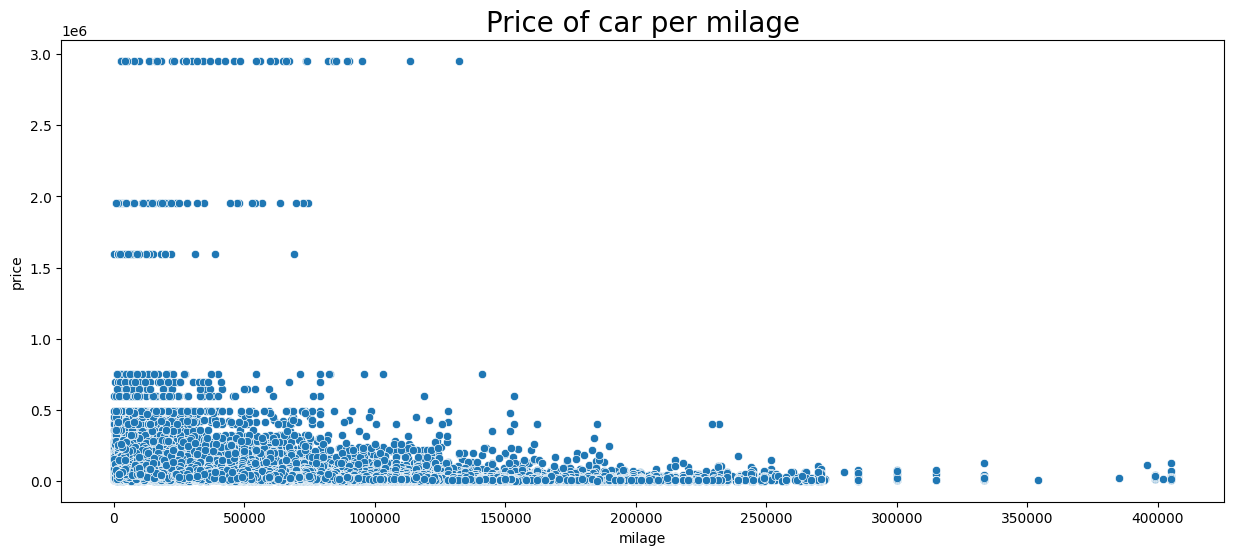

In [17]:
plt.figure(figsize=(15,6))
sns.scatterplot(data=df,x="milage",y="price")
plt.title("Price of car per milage",fontsize=20)
plt.show()
#we notice that most of the values are under 1500000 so we need to remove the outlier values 

In [18]:
pricemin=df["price"].min()

In [19]:
pricemax=df["price"].max()
pricemax

2954083

In [20]:
df.loc[df["price"]>100000].shape
#only 148 out of 188533 have a price higher than 100000

(10437, 13)

In [21]:
df.loc[df["price"]>=pricemax]
#we notice a lot of illogical data (high prices for cars that dont deserve it at all)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
220,220,Ford,F-150 XLT,2021,26315,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Agate Black Metallic,Black,None reported,Yes,2954083
1880,1880,Chrysler,300C Base,2003,55900,Gasoline,340.0HP 5.7L 8 Cylinder Engine Gasoline Fuel,5-Speed A/T,Beige,Beige,None reported,Yes,2954083
13838,13838,Toyota,Highlander SE,2014,85000,Gasoline,3.5L V6 24V PDI DOHC,8-Speed Automatic,Green,Black,None reported,Yes,2954083
14693,14693,Hyundai,Santa Fe SEL,2022,13865,Gasoline,2.5L I4 16V PDI DOHC,8-Speed Automatic,Black,Black,None reported,Yes,2954083
16034,16034,Mercedes-Benz,SL-Class SL500 Roadster,2005,34068,Gasoline,302.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Beige,None reported,Yes,2954083
18946,18946,Audi,S4 Base,2004,73500,Gasoline,340.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed M/T,Blue,Beige,None reported,Yes,2954083
21814,21814,RAM,1500 Laramie,2022,16156,Gasoline,5.7L V8 16V MPFI OHV,8-Speed Automatic,Diamond Black,Black,None reported,Yes,2954083
36615,36615,Ford,Excursion Limited Ultimate,2002,89900,Diesel,325.0HP 6.0L 8 Cylinder Engine Diesel Fuel,5-Speed A/T,Gold,Gold,None reported,Yes,2954083
42177,42177,Ford,Mustang GT,2005,82000,Gasoline,300.0HP 4.6L 8 Cylinder Engine Gasoline Fuel,5-Speed M/T,Silver,Black,None reported,Yes,2954083
42219,42219,Land,Rover Range Rover 3.0L V6 Supercharged HSE,2021,29850,Gasoline,380.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Black,None reported,Yes,2954083


In [22]:
(df.loc[(df["price"]<=1000000)])["price"].max()

749950

In [23]:
df=df.loc[df["price"]<=749950]

In [24]:
brands=df["brand"].unique()
brands

array(['MINI', 'Lincoln', 'Chevrolet', 'Genesis', 'Mercedes-Benz', 'Audi',
       'Ford', 'BMW', 'Tesla', 'Cadillac', 'Land', 'GMC', 'Toyota',
       'Hyundai', 'Volvo', 'Volkswagen', 'Buick', 'Rivian', 'RAM',
       'Hummer', 'Alfa', 'INFINITI', 'Jeep', 'Porsche', 'McLaren',
       'Honda', 'Lexus', 'Dodge', 'Nissan', 'Jaguar', 'Acura', 'Kia',
       'Mitsubishi', 'Rolls-Royce', 'Maserati', 'Pontiac', 'Saturn',
       'Bentley', 'Mazda', 'Subaru', 'Ferrari', 'Aston', 'Lamborghini',
       'Chrysler', 'Lucid', 'Lotus', 'Scion', 'smart', 'Karma',
       'Plymouth', 'Suzuki', 'FIAT', 'Saab', 'Bugatti', 'Mercury',
       'Polestar', 'Maybach'], dtype=object)

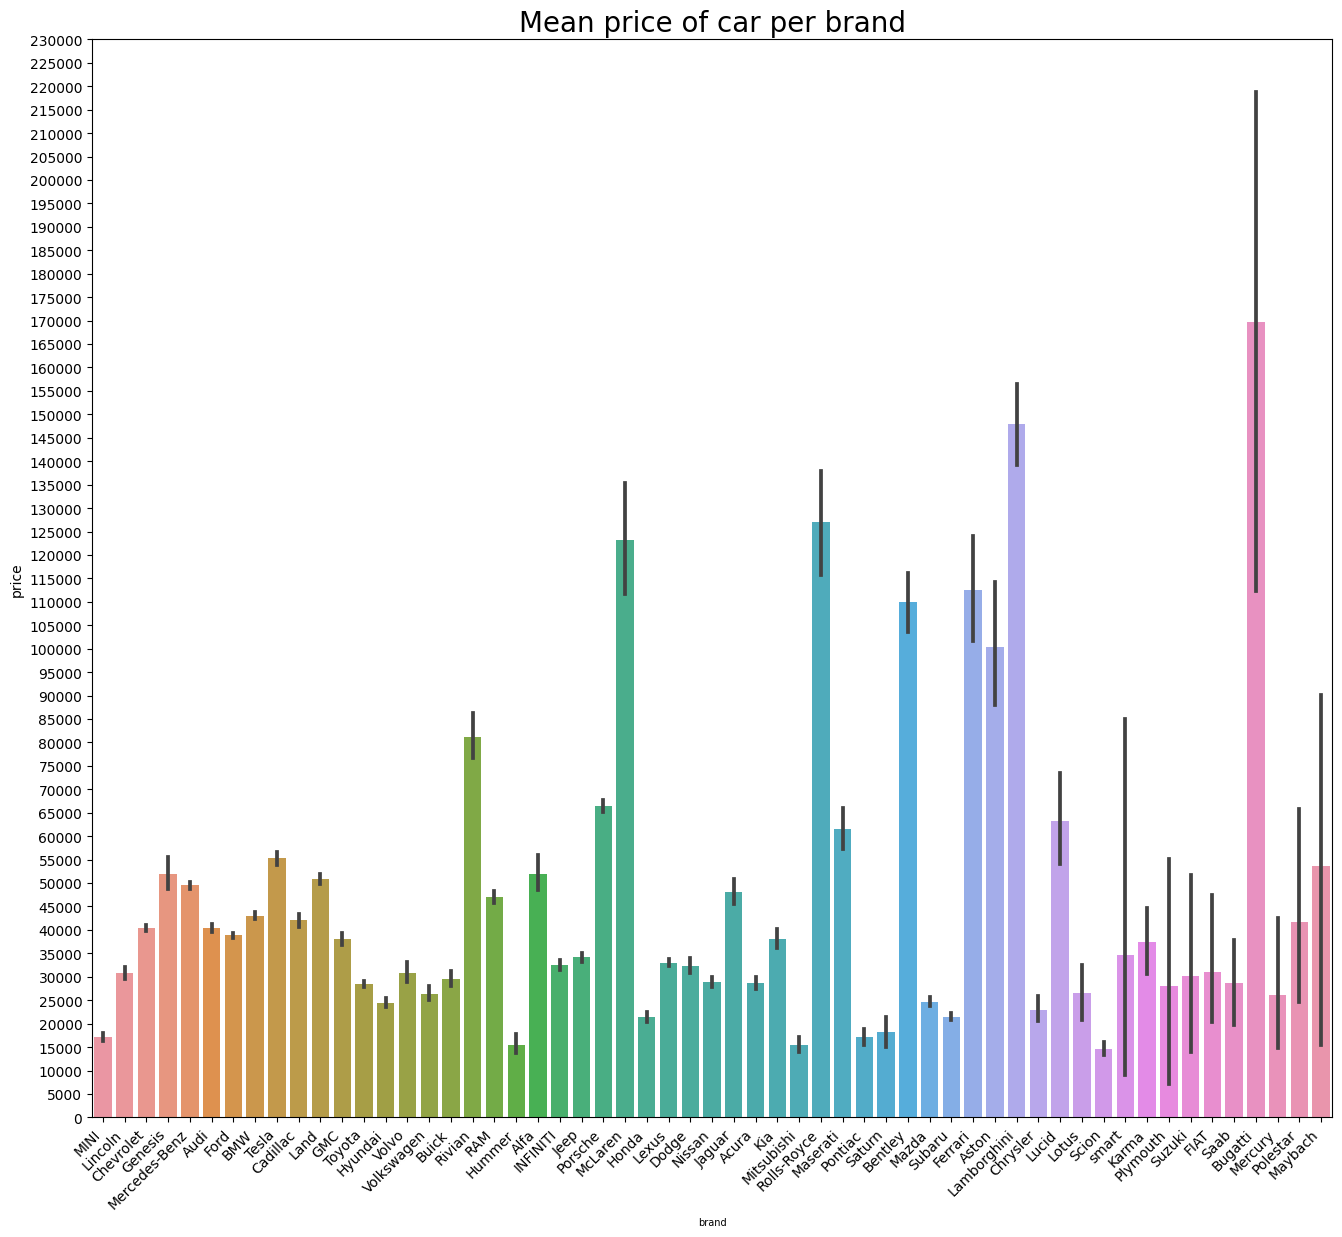

In [25]:
plt.figure(figsize=(16,14))
sns.barplot(data=df,x="brand",y="price",estimator="mean")
plt.title("Mean price of car per brand",fontsize=20)
plt.xlabel("brand",fontsize=7)
plt.xticks(rotation=45, ha='right')
interval = 5000
y_min, y_max = plt.ylim()  # Get the current y-axis limits
ticks = np.arange(int(np.floor(y_min / interval)) * interval, int(np.ceil(y_max / interval)) * interval + interval, interval)
plt.yticks(ticks)

plt.show()
plt.show()

In [26]:
luxury=[]
for brand in brands:
    if (df.loc[df["brand"]==brand]["price"].mean()>=45000):
        luxury.append(brand)
    


In [27]:
# Initialize the new column with a default value using .loc
df.loc[:, 'brand_type'] = 'non-luxury'

# Update the new column for luxury brands using .loc
df.loc[df['brand'].isin(luxury), 'brand_type'] = 'luxury'


/tmp/ipykernel_37/2108862001.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'brand_type'] = 'non-luxury'


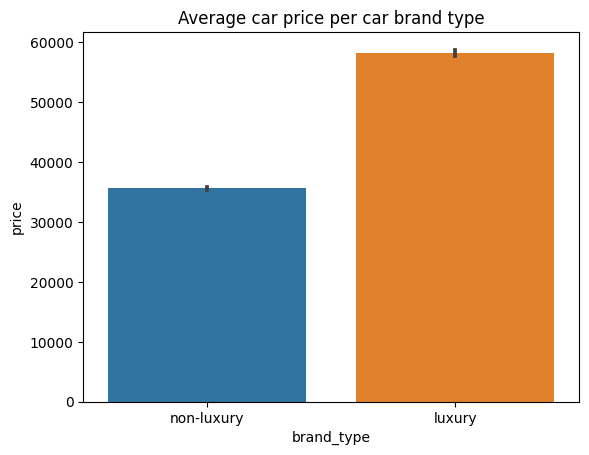

In [28]:
sns.barplot(data=df,x="brand_type",y="price",estimator="mean")
plt.title("Average car price per car brand type")
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


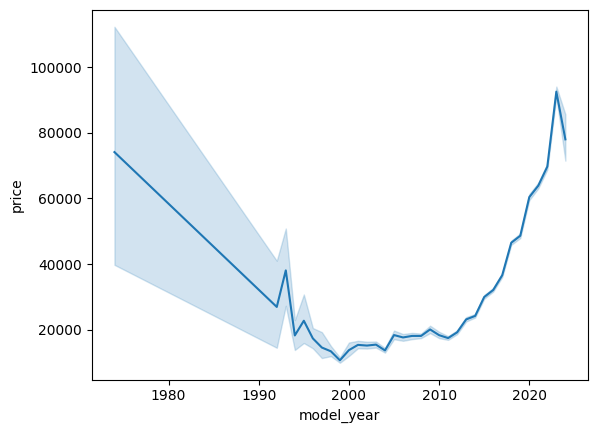

<Figure size 2000x1000 with 0 Axes>

In [29]:

sns.lineplot(data=df,x="model_year",y="price")
plt.figure(figsize=(20,10))
plt.show()
#we notice that the prices lower until 1990 then get high again after 2010

In [30]:
df.loc[:,"car_age"]="old"

/tmp/ipykernel_37/2630193208.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,"car_age"]="old"


In [31]:
df.loc[df["model_year"]>2010,"car_age"]="new"

(0         False
 1         False
 2         False
 3          True
 4          True
           ...  
 188528     True
 188529     True
 188530     True
 188531     True
 188532     True
 Name: model_year, Length: 188385, dtype: bool,
 'car_age')

In [32]:
df.loc[(df["model_year"]<=2010) & (df["model_year"]>=1990),"car_age"]="middle aged"

ValueError: could not convert string to float: 'MINI'

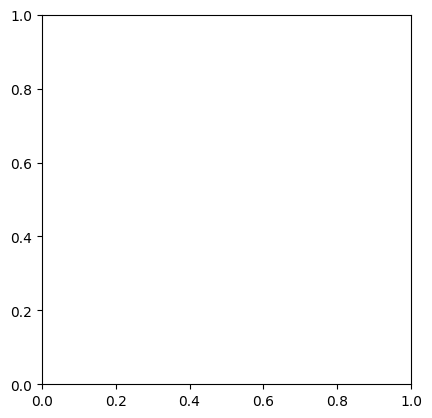

In [124]:
palette_color = sns.color_palette('dark')
plt.pie(df, labels=df["car_age"], colors=palette_color, autopct='%.0f%%') 
plt.show()

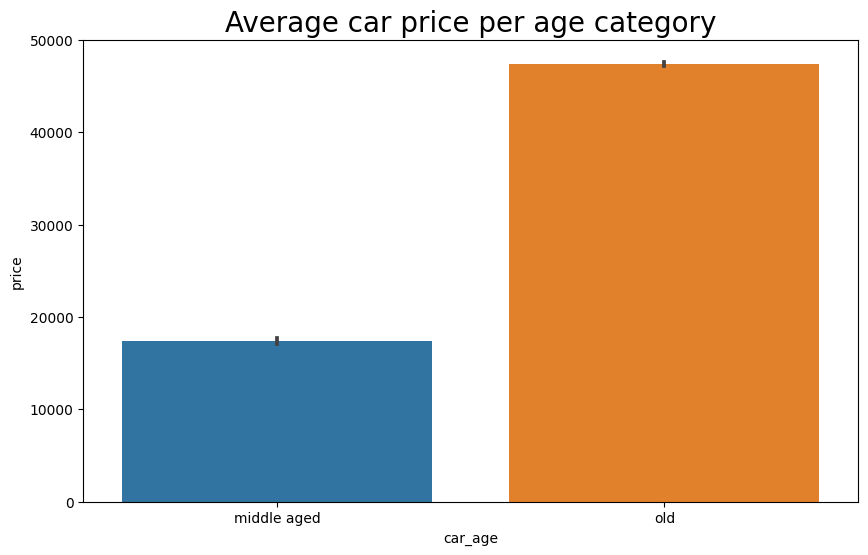

In [33]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df,x="car_age",y="price",estimator="mean")
plt.title("Average car price per age category",fontsize=20)
plt.show()

In [37]:
df["fuel_type"].value_counts()

fuel_type
Gasoline          166558
E85 Flex Fuel      10486
Hybrid              6839
Diesel              3950
Plug-In Hybrid       521
–                     31
Name: count, dtype: int64

<Axes: xlabel='fuel_type', ylabel='price'>

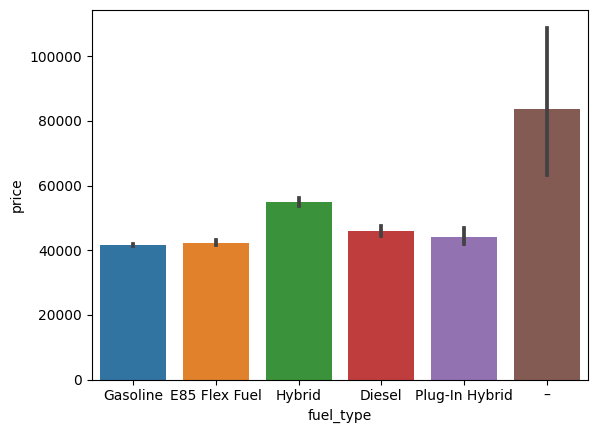

In [39]:
sns.barplot(data=df,x="fuel_type",y="price",estimator="mean")

**Modeling**

In [41]:
encoder = OneHotEncoder(sparse_output=False)
# Apply one-hot encoding to the categorical columns
one_hot_encoded = encoder.fit_transform(df[df_cat])

#Create a DataFrame with the one-hot encoded columns
#We use get_feature_names_out() to get the column names for the encoded data
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(df_cat))

# Concatenate the one-hot encoded dataframe with the original dataframe
df_encoded = pd.concat([df, one_hot_df], axis=1)

# Drop the original categorical columns
df_encoded = df_encoded.drop(df_cat, axis=1)

In [46]:

from sklearn.preprocessing import OrdinalEncoder

# Instantiate the OrdinalEncoder and name it ordinalencoder
ordinalencoder = OrdinalEncoder(categories=[['non-luxury', 'luxury']])

# Fit and transform the 'car_type' column
df_encoded['brand_type'] = ordinalencoder.fit_transform(df_encoded[['brand_type']])

df_encoded
df_encoded

ValueError: Found unknown categories [nan] in column 0 during fit

In [49]:
df_encoded=df_encoded[:188533]

In [50]:
df_encoded

,id,model_year,milage,price,brand_type,car_age,brand_Acura,brand_Alfa,brand_Aston,brand_Audi,...,int_col_Walnut,int_col_Whisper Beige,int_col_White,int_col_White / Brown,int_col_Yellow,int_col_–,accident_At least 1 accident or damage reported,accident_None reported,clean_title_No,clean_title_Yes
0,0.0,2007.0,213000.0,4200.0,non-luxury,middle aged,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.0,2002.0,143250.0,4999.0,non-luxury,middle aged,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,2.0,2002.0,136731.0,13900.0,non-luxury,middle aged,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,3.0,2017.0,19500.0,45000.0,luxury,old,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,4.0,2021.0,7388.0,97500.0,luxury,old,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183262,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
183468,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
185197,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
186234,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [17]:
le=LabelEncoder()

In [18]:
for col in df_cat:
    df[col]=le.fit_transform(df[col])

I-XGBoostRegressor

In [53]:

# Defining the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),
    'gamma': uniform(0, 5),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# Initializing the XGBoost Regressor
xgb = xg.XGBRegressor(objective='reg:squarederror')

# Seting up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50, 
    scoring='neg_root_mean_squared_error', 
    cv=5,  
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fitting RandomizedSearchCV
random_search.fit(X_train, y_train)

# Getting the best model
best_model = random_search.best_estimator_

# Printing the best parameters and the best score
print("Best Parameters:", random_search.best_params_)
print("Best RMSE Score:", -random_search.best_score_)

# Predicingt on the test set and calculate RMSE
y_pred = best_model.predict(X_test)
test_rmse = np.sqrt(MSE(y_test, y_pred))
print("Test RMSE:", test_rmse)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.6872700594236812, gamma=4.75357153204958, learning_rate=0.22959818254342154, max_depth=7, n_estimators=714, reg_alpha=0.44583275285359114, reg_lambda=0.09997491581800289, subsample=0.7296244459829335; total time=  14.4s
[CV] END colsample_bytree=0.6668543055695109, gamma=0.7143340896097039, learning_rate=0.20526654188465587, max_depth=7, n_estimators=869, reg_alpha=0.7219987722668247, reg_lambda=0.9385527090157502, subsample=0.5003893829205072; total time=  16.0s
[CV] END colsample_bytree=0.9961057796456088, gamma=3.0874075481385828, learning_rate=0.19349594814648427, max_depth=14, n_estimators=956, reg_alpha=0.2912291401980419, reg_lambda=0.6118528947223795, subsample=0.569746930326021; total time= 1.7min


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.6872700594236812, gamma=4.75357153204958, learning_rate=0.22959818254342154, max_depth=7, n_estimators=714, reg_alpha=0.44583275285359114, reg_lambda=0.09997491581800289, subsample=0.7296244459829335; total time=  14.6s
[CV] END colsample_bytree=0.6668543055695109, gamma=0.7143340896097039, learning_rate=0.20526654188465587, max_depth=7, n_estimators=869, reg_alpha=0.7219987722668247, reg_lambda=0.9385527090157502, subsample=0.5003893829205072; total time=  16.2s
[CV] END colsample_bytree=0.9961057796456088, gamma=3.0874075481385828, learning_rate=0.19349594814648427, max_depth=14, n_estimators=956, reg_alpha=0.2912291401980419, reg_lambda=0.6118528947223795, subsample=0.569746930326021; total time= 1.7min
[CV] END colsample_bytree=0.6872700594236812, gamma=4.75357153204958, learning_rate=0.22959818254342154, max_depth=7, n_estimators=714, reg_alpha=0.44583275285359114, reg_lambda=0.09997491581800289, subsample=0.7296244459829335; total time=  14.0s
[CV] END

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Example values; replace with your own grid
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 0.5, 1.0]
}
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metric for regression
scoring = make_scorer(MSE, greater_is_better=False)  # Neg MSE is used, so `greater_is_better` is False

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=5,
    refit=True
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set and calculate RMSE
y_pred = best_model.predict(X_test)
test_rmse = np.sqrt(MSE(y_test, y_pred))
print("Test RMSE:", test_rmse)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE Score:", -grid_search.best_score_)  # RMSE is negated in scoring

Fitting 5 folds for each of 6561 candidates, totalling 32805 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0.1, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0.1, subsample=0.9; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0.1, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0.5, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0.5, subsample=0.9; total time=   1.7s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=0.5, subsample=1.0; total time=   1.6s
[CV] END c

In [19]:
df

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,31,495,2007,213000,2,116,38,312,71,1,1,4200
1,1,28,930,2002,143250,2,366,38,263,10,0,1,4999
2,2,9,1575,2002,136731,1,640,38,38,71,1,1,13900
3,3,16,758,2017,19500,2,863,49,29,14,1,1,45000
4,4,36,1077,2021,7388,2,259,23,29,10,1,1,97500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,8,604,2017,49000,2,866,49,304,10,1,1,27500
188529,188529,36,206,2018,28600,2,770,31,304,14,0,1,30000
188530,188530,36,223,2021,13650,2,921,23,304,14,1,1,86900
188531,188531,3,1471,2022,13895,2,512,1,82,14,1,1,84900


In [20]:
X_train,X_test,y_train,y_test=train_test_split(df.drop(columns=["id","price"]),df["price"],test_size=0.3, random_state=42)

In [31]:
#this code is due written due to an error obtained at the end of the code above due to a typo so no need to use it because the error is already corrected
BestParameters={'colsample_bytree': 0.5354704584999639, 'gamma': 1.983919136069442, 'learning_rate': 0.02523055931181908, 'max_depth': 5, 'n_estimators': 570, 'reg_alpha': 0.027616771873704704, 'reg_lambda': 0.5788648955075587, 'subsample': 0.7192370615090435}
best_model=xg.XGBRegressor(objective="reg:squarederror",**BestParameters)
best_model.fit(X_train,y_train)
y_pred=best_model.predict(X_test)
print("RMSE:",np.sqrt(MSE(y_test,y_pred)))

RMSE: 66191.10622699182


In [27]:
best_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5354704584999639, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=1.983919136069442,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02523055931181908,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=570, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [32]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            125690 non-null  int64 
 1   brand         125690 non-null  object
 2   model         125690 non-null  object
 3   model_year    125690 non-null  int64 
 4   milage        125690 non-null  int64 
 5   fuel_type     122307 non-null  object
 6   engine        125690 non-null  object
 7   transmission  125690 non-null  object
 8   ext_col       125690 non-null  object
 9   int_col       125690 non-null  object
 10  accident      124058 non-null  object
 11  clean_title   111451 non-null  object
dtypes: int64(3), object(9)
memory usage: 11.5+ MB


In [33]:
dt.loc[dt["accident"].isna(),"accident"]="At least 1 accident or damage reported"

In [34]:
dt.loc[(dt['accident']=='None reported') & (dt['clean_title'].isna()),"clean_title"]="Yes"

In [35]:
dt.loc[(dt['accident']=='At least 1 accident or damage reported') & (dt['clean_title'].isna()),"clean_title"]="No"

In [36]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            125690 non-null  int64 
 1   brand         125690 non-null  object
 2   model         125690 non-null  object
 3   model_year    125690 non-null  int64 
 4   milage        125690 non-null  int64 
 5   fuel_type     122307 non-null  object
 6   engine        125690 non-null  object
 7   transmission  125690 non-null  object
 8   ext_col       125690 non-null  object
 9   int_col       125690 non-null  object
 10  accident      125690 non-null  object
 11  clean_title   125690 non-null  object
dtypes: int64(3), object(9)
memory usage: 11.5+ MB


In [37]:
dt["fuel_type"].unique()

array(['Gasoline', 'Hybrid', 'Diesel', 'E85 Flex Fuel', nan,
       'Plug-In Hybrid', '–', 'not supported'], dtype=object)

In [38]:
# Flex pattern
dt.loc[(dt['fuel_type'].isna()) | dt['fuel_type'].isin(['–', 'not supported']) & dt['engine'].str.contains("Flex", case=False, na=False), 'fuel_type'] = 'E85 Flex Fuel'

# Hybrid patterns
dt.loc[(dt['fuel_type'].isna()) | dt['fuel_type'].isin(['–', 'not supported']) & dt['engine'].str.contains("Dual", case=False, na=False), 'fuel_type'] = 'Hybrid'
dt.loc[(dt['fuel_type'].isna()) | dt['fuel_type'].isin(['–', 'not supported']) & dt['engine'].str.contains("Electric", case=False, na=False), 'fuel_type'] = 'Hybrid'
dt.loc[(dt['fuel_type'].isna()) | dt['fuel_type'].isin(['–', 'not supported']) & dt['engine'].str.contains("Battery", case=False, na=False), 'fuel_type'] = 'Hybrid'
dt.loc[(dt['fuel_type'].isna()) | dt['fuel_type'].isin(['–', 'not supported']) & dt['engine'].str.contains("kW", case=False, na=False), 'fuel_type'] = 'Hybrid'
dt.loc[(dt['fuel_type'].isna()) | dt['fuel_type'].isin(['–', 'not supported']) & dt['engine'].str.contains("AH", case=False, na=False), 'fuel_type'] = 'Hybrid'
dt.loc[(dt['fuel_type'].isna()) | dt['fuel_type'].isin(['–', 'not supported']) & dt['brand'].str.contains("Tesla", case=False, na=False), 'fuel_type'] = 'Hybrid'
dt.loc[(dt['fuel_type'].isna()) | dt['fuel_type'].isin(['–', 'not supported']) & dt['model'].str.contains("Hybrid", case=False, na=False), 'fuel_type'] = 'Hybrid'

# Gasoline patterns
dt.loc[(dt['fuel_type'].isna()) | dt['fuel_type'].isin(['–', 'not supported']) & dt['engine'].str.contains("GDI", case=False, na=False), 'fuel_type'] = 'Gasoline'
dt.loc[(dt['fuel_type'].isna()) | dt['fuel_type'].isin(['–', 'not supported']) & dt['engine'].str.contains("PDI", case=False, na=False), 'fuel_type'] = 'Gasoline'
dt.loc[(dt['fuel_type'].isna()) | dt['fuel_type'].isin(['–', 'not supported']) & dt['engine'].str.contains("OHV", case=False, na=False), 'fuel_type'] = 'Gasoline'
dt.loc[(dt['fuel_type'].isna()) | dt['fuel_type'].isin(['–', 'not supported']) & dt['engine'].str.contains("MPFI", case=False, na=False), 'fuel_type'] = 'Gasoline'
dt.loc[(dt['fuel_type'].isna()) | dt['fuel_type'].isin(['–', 'not supported']) & dt['engine'].str.contains("TFSI", case=False, na=False), 'fuel_type'] = 'Gasoline'
dt.loc[(dt['fuel_type'].isna()) | dt['fuel_type'].isin(['–', 'not supported']) & dt['engine'].str.contains("DOHC", case=False, na=False), 'fuel_type'] = 'Gasoline'
dt.loc[(dt['fuel_type'].isna()) | dt['fuel_type'].isin(['–', 'not supported']) & dt['engine'].str.contains("Gasoline", case=False, na=False), 'fuel_type'] = 'Gasoline'
dt.loc[(dt['fuel_type'].isna()) | dt['fuel_type'].isin(['–', 'not supported']) & (dt['model_year'] < 2020), 'fuel_type'] = 'Gasoline'

# Diesel patterns
dt.loc[(dt['fuel_type'].isna()) | dt['fuel_type'].isin(['–', 'not supported']) & dt['engine'].str.contains("Diesel", case=False, na=False), 'fuel_type'] = 'Diesel'


In [40]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            125690 non-null  int64 
 1   brand         125690 non-null  object
 2   model         125690 non-null  object
 3   model_year    125690 non-null  int64 
 4   milage        125690 non-null  int64 
 5   fuel_type     125690 non-null  object
 6   engine        125690 non-null  object
 7   transmission  125690 non-null  object
 8   ext_col       125690 non-null  object
 9   int_col       125690 non-null  object
 10  accident      125690 non-null  object
 11  clean_title   125690 non-null  object
dtypes: int64(3), object(9)
memory usage: 11.5+ MB


In [41]:
for col in df_cat:
    dt[col]=le.fit_transform(dt[col])

In [42]:
dt

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,26,1388,2015,98000,2,326,16,302,10,1,1
1,188534,26,1375,2020,9142,3,787,31,261,14,1,1
2,188535,14,636,2022,28121,2,541,3,302,57,1,1
3,188536,3,182,2016,61258,2,193,39,259,14,1,1
4,188537,3,181,2018,59000,2,365,38,127,14,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
125685,314218,36,759,2014,83315,2,732,23,29,14,1,1
125686,314219,3,1248,2019,29336,2,511,39,302,14,1,1
125687,314220,3,184,2012,77634,2,673,38,29,14,1,1
125688,314221,3,1244,2012,112000,2,673,38,29,14,1,1


In [43]:
x=df.drop(columns=["id","price"])
y=df["price"]

In [44]:
x

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,31,495,2007,213000,2,116,38,312,71,1,1
1,28,930,2002,143250,2,366,38,263,10,0,1
2,9,1575,2002,136731,1,640,38,38,71,1,1
3,16,758,2017,19500,2,863,49,29,14,1,1
4,36,1077,2021,7388,2,259,23,29,10,1,1
...,...,...,...,...,...,...,...,...,...,...,...
188528,8,604,2017,49000,2,866,49,304,10,1,1
188529,36,206,2018,28600,2,770,31,304,14,0,1
188530,36,223,2021,13650,2,921,23,304,14,1,1
188531,3,1471,2022,13895,2,512,1,82,14,1,1


In [46]:
x["clean_title"]=pd.to_numeric(x["clean_title"])

In [47]:
best_model.fit(x,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5354704584999639, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=1.983919136069442,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02523055931181908,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=570, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [207]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   brand         188533 non-null  int64
 1   model         188533 non-null  int64
 2   model_year    188533 non-null  int64
 3   milage        188533 non-null  int64
 4   fuel_type     188533 non-null  int64
 5   engine        188533 non-null  int64
 6   transmission  188533 non-null  int64
 7   ext_col       188533 non-null  int64
 8   int_col       188533 non-null  int64
 9   accident      188533 non-null  int64
 10  clean_title   188533 non-null  int64
dtypes: int64(11)
memory usage: 15.8 MB


In [208]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   id            125690 non-null  int64
 1   brand         125690 non-null  int64
 2   model         125690 non-null  int64
 3   model_year    125690 non-null  int64
 4   milage        125690 non-null  int64
 5   fuel_type     125690 non-null  int64
 6   engine        125690 non-null  int64
 7   transmission  125690 non-null  int64
 8   ext_col       125690 non-null  int64
 9   int_col       125690 non-null  int64
 10  accident      125690 non-null  int64
 11  clean_title   125690 non-null  int64
dtypes: int64(12)
memory usage: 11.5 MB


In [48]:
id=dt["id"]
    

In [50]:
x_t=dt.drop(columns="id")

In [51]:
pred=best_model.predict(x_t)

In [52]:
output = pd.DataFrame({'id': id, 'price': pred})
output.to_csv('submissions.csv', index=False)